# LightGBM interpretability

LightGBM offers a scalable solution that accomodates tabular and categorical inputs out of the box. 

### Setup

In [1]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

### Load Configuration

In [2]:
"""
Loads common configuration parameters
"""
import utils.configuration_manager as configuration_manager
from pathlib import PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = configuration_manager.Config(config_path)

# Assumes parquet directory as input
input_path = config.input_path
print('Input path: '+ input_path)

# For result storage
output_directory = config.output_directory
print('Output path: ' + output_directory)

Loading configuration from: /home/justin/Code/interpretability_experiment/config.ini
Input path: data/2018_Yellow_Taxi_Trip_Data
Output path: output


### Start local Dask Client

In [3]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
#     cluster = LocalCluster(dashboard_address=':20100', memory_limit='4G')
    cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

Setting new client
<Client: 'tcp://127.0.0.1:39311' processes=5 threads=10, memory=26.87 GB>


Client Scheduler: tcp://127.0.0.1:39311 Dashboard: http://127.0.0.1:20100/status,Cluster Workers: 5 Cores: 10 Memory: 26.87 GB


### Dask dataframe loader

In [4]:
import dask.dataframe as dd
import fastparquet

In [5]:
ddf = dd.read_parquet(input_path)

In [6]:
ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
index,,,,,,,,,,,,,,,,,
0,1,2018-12-03 09:58:01,2018-12-03 10:14:17,1.0,1.20,1,N,186,161,1,11.0,0.0,0.5,2.95,0.00,0.3,14.75
1,2,2018-12-03 09:41:32,2018-12-03 10:20:08,1.0,12.03,1,N,138,162,1,39.0,0.0,0.5,9.11,5.76,0.3,54.67
2,2,2018-12-03 08:54:36,2018-12-03 08:59:35,2.0,0.86,1,N,151,166,1,5.5,0.0,0.5,1.26,0.00,0.3,7.56
3,2,2018-12-03 09:02:08,2018-12-03 09:07:16,2.0,1.09,1,N,166,238,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
4,2,2018-12-03 09:10:10,2018-12-03 09:21:32,2.0,1.78,1,N,238,75,1,9.5,0.0,0.5,2.06,0.00,0.3,12.36


In [7]:
ddf.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag               object
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

### Define what we are trying to model

Let's try to create an estimator for the passenger tip, which I suspect is something pretty difficult to guess outright. 

Then we can look into other questions like whether the passenger count might affect the tip as a kind of social pressure. 

In [8]:
columns = [x for x in ddf.columns.values]
print(columns)

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


In [20]:
# Note - total_amount is excluded from the input list 
input_columns = ['VendorID', 
                 'passenger_count', 'trip_distance', 'RatecodeID', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
                 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount_wo_tip']

In [21]:
target = 'tip_amount'

In [22]:
"""
We'll subtract the tip_amount from the total_amount to prevent any leakage, 
using a new total_amount_wo_tip column.
"""
ddf['total_amount_wo_tip'] = ddf['total_amount'] - ddf['tip_amount']

In [23]:
# print(ddf.head())

### LightGBM Model

In [24]:
"""
LightGBM parameters
"""
import lightgbm as lgb
from dask_ml.model_selection import train_test_split

ts = 'tpep_pickup_datetime'

In [37]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}

def train_model(df_block):
    X = df_block[input_columns]
    y = df_block[target]
    
    # Make training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8)
    
#     # Transform to pandas dataframe for LightGBM support 
#     X_train, X_test, y_train, y_test = pandafy(X_train, X_test, y_train, y_test)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    #https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm
    # https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
    lgb_model = lgb.train(lgb_params,
                          lgb_train,
                          num_boost_round=100,
                          valid_sets=lgb_eval,
                          early_stopping_rounds=5)
    return lgb_model


In [49]:
import pandas as pd

def concatenate(dfs):
    """
    From https://stackoverflow.com/questions/45639350/retaining-categorical-dtype-upon-dataframe-concatenation
    Concatenate while preserving categorical columns.
    NB: We change the categories in-place for the input dataframes"""
    from pandas.api.types import union_categoricals
    import pandas as pd
    # Iterate on categorical columns common to all dfs
    for col in set.intersection(
        *[
            set(df.select_dtypes(include='category').columns)
            for df in dfs
        ]
    ):
        # Generate the union category across dfs for this column
        uc = union_categoricals([df[col] for df in dfs])
        # Change to union category for all dataframes
        for df in dfs:
            df[col] = pd.Categorical( df[col], categories=uc.categories )
    return pd.concat(dfs)

columns_to_keep = input_columns + [target]

dfs = []
for i in range(10):
    ddf_partition = ddf[columns_to_keep].get_partition(i)
    df_temp = ddf_partition.compute()
    dfs.append(df_temp)

# from pandas.api.types import union_categoricals 
df = concatenate(dfs)

In [50]:
print(df.dtypes)

VendorID                 category
passenger_count           float64
trip_distance             float64
RatecodeID               category
PULocationID             category
DOLocationID             category
payment_type             category
fare_amount               float64
extra                     float64
mta_tax                   float64
tolls_amount              float64
improvement_surcharge     float64
total_amount_wo_tip       float64
tip_amount                float64
dtype: object


In [52]:
lightgbm_model = train_model(df)

[1]	valid_0's l2: 9.1798	valid_0's auc: 0.966594
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 9.09021	valid_0's auc: 0.967777
[3]	valid_0's l2: 9.0815	valid_0's auc: 0.967171
[4]	valid_0's l2: 9.00246	valid_0's auc: 0.968175
[5]	valid_0's l2: 8.99547	valid_0's auc: 0.967334
[6]	valid_0's l2: 8.92748	valid_0's auc: 0.967934
[7]	valid_0's l2: 8.86792	valid_0's auc: 0.968449
[8]	valid_0's l2: 8.86366	valid_0's auc: 0.968434
[9]	valid_0's l2: 8.81165	valid_0's auc: 0.96863
[10]	valid_0's l2: 8.76586	valid_0's auc: 0.968997
[11]	valid_0's l2: 8.76232	valid_0's auc: 0.968689
[12]	valid_0's l2: 8.75953	valid_0's auc: 0.968376
[13]	valid_0's l2: 8.72059	valid_0's auc: 0.968782
[14]	valid_0's l2: 8.68572	valid_0's auc: 0.969123
[15]	valid_0's l2: 8.65451	valid_0's auc: 0.969395
[16]	valid_0's l2: 8.62689	valid_0's auc: 0.969702
[17]	valid_0's l2: 8.60221	valid_0's auc: 0.96977
[18]	valid_0's l2: 8.57983	valid_0's auc: 0.969961
[19]	valid_0's l2: 8.55998	valid_0'

### Try built-in explainer

Now we'll take a look at possible contributors to the final tip received. Importantly, these will not tell you the direction of the relationship and cannot be taken at face value.

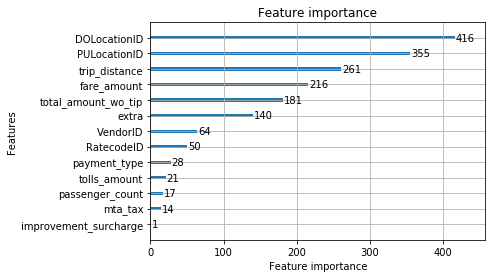

In [57]:
# Default feature importance is "split" which represents the number of times the feature is used by the model
lgb.plot_importance(lightgbm_model)

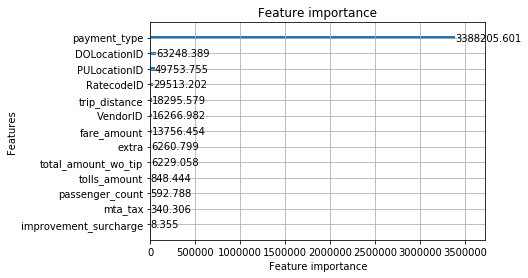

In [60]:
# Gain feature importance contains the total information gain the model has by using this feature
lgb.plot_importance(lightgbm_model, importance_type="gain")

Looking at whether we are plotting importance by the number of times the feature is used by the model (1st case) or the information gained by the use of a particular branch point (second case) we get pretty different results. 

Readings:
Interpretability with XGBoost
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

For census data and XGBoost:
https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html

It seems like pick-up and drop-off location seem to be strong predictors, but we might have to control for the distance. 


In [ ]:
### Pay

Payment_type from feature importance derived by 'gain' seems promising. Let's investigate. 

In [ ]:
"""
A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
"""

In [71]:
# For local dataset
print(df['payment_type'].value_counts())

1    2475032
2     938645
3      16096
4       5434
Name: payment_type, dtype: int64


In [74]:
# For global dataset
print(ddf['payment_type'].value_counts().compute())

1    77928307
2    33556849
3      582599
4      166868
5           3
Name: payment_type, dtype: int64


It's possible that 'no-charge' in this case guaranties no-tip, but that isn't a particularly useful finding. Perhaps we should remove this from the training set.

### Use SHAP explainer

In [55]:
import shap
shap.initjs() 

ModuleNotFoundError: No module named 'shap'